In [101]:
import urllib.request as urllib2
import urllib
import re
import json
import pandas as pd
import numpy as np
import os
import mwparserfromhell
import pickle
import re
import networkx as nx
import pandas as pd
import numpy as np
from numpy import mean
import os
from collections import Counter
import pickle
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import collections
import operator
from operator import itemgetter
from wordcloud import WordCloud
from infomap import Infomap
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import community
import matplotlib as mtpl
import copy
import math
import csv
import random, os, math, pickle, itertools, nltk, re, pprint, pandas as pd, numpy as np, copy, seaborn as sns, matplotlib.pyplot as plt

%matplotlib inline

<a id='2-1-stats'></a>
## 2.1 Write about your choices in the data cleaning and preprocessing

<a id='2-1-1-wikis'></a>
### 2.1.1 Wikis

Write about your choices in data cleaning and preprocessing

---

<a id='2-2-stats'></a>
## 2.2 Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

<a id='2-2-1-wikis'></a>
### 2.2.1 Wikis

Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

---

<a id='tools'></a>
# 3. Tools, theory and analysis. Describe the process of theory to insight
* **Talk about how you've worked with the text, including regular expressions, unicode, etc.**
* **Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you are solving.**
* **How did you use the tools to understand your dataset?**

<font color='red'>
Setup:

* Explain the overall idea
* Analysis step 1
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome
* Analysis step 2
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome
* Analysis step 3
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome


<a id='3-2-books'></a>
## 3.1 Wikis
Multiple different analyses were performed...


* [3.1.0 Wiki analysis setup and preparation](#3-1-0-preparation)
* [3.1.1 Wiki network creation and visualizations](#3-1-1-networkcreation)
* [3.1.2 Wiki network analyses](#3-1-2-networkanalyses)
* [3.1.3 Wiki network community detection](#3-1-3-networkcommunitydetection)
* [3.1.4 Wiki page sentiment analysis](#3-1-4-networksentiments)
* [3.1.5 Interactive Wiki network](#3-1-5-interactivenetwork)





<a id='3-1-0-preparation'></a>
### 3.1.0 Wiki analysis setup and preparation


**Fetching dataframe**


In [21]:
# Defining home directory

hd = os.getcwd()

# Fetching the WikiPage dataframe

with open(hd + '/Wikis/dataframes/cleaned_wiki_df.pkl', 'rb') as f:
    df_wiki = pickle.load(f)
    
df_wiki.head(2)

,wiki,book,alternative_wiki,text,links,house,type,blood,nationality,gender,hair,eyes,species
0,Tufty,1,None,pet individual arabella figg tufty one arabell...,"[Dudley Dursley, Mr Tibbles, Harry Potter, Sno...",Unknown,Pet,Unknown,Unknown,Male,Unknown,Unknown,Unknown
1,Mirror of Erised,1,None,mirror storage dungeon room requirement hogwar...,"[Aberforth Dumbledore, Boggart, Gregory Goyle,...",Unknown,Object,Unknown,Unknown,Male,Unknown,Unknown,Unknown


**Defining functions and objects for visualizations**

In [6]:
# Getting the ForceAtlas algorithm configuration ready

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=False
)

In [7]:
# For plotting in- and out-degree distributions. 

def display_histogram_and_loglog_distributions(G_type, print_str, title, bins):
    # Function that displays histogram and log-log of network side-by-side.
    # Takes in network type, print string, title, and number of bins for histogram
    # Typically gets (G.in_degree() or G.out_degree())
    
    degs = [deg for (node, deg) in G_type]
    hist, bin_edges = np.histogram(degs, bins=bins)
    degree_sequence = sorted([d for n, d in G_type], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # Side-by-side comparison
    fig.suptitle(title, size=18)
    
    axs[0].hist(degs, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title    
    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.show()
    
def make_scatter_plots(G, with_percentiles = False, equalize_y_axis = False):
    # A function that makes side-by-side scatterplots of in-degree and out-degree distributions
    # Takes in Network and two booleans, self-explanatory
    
    node_indices = [i for i in range(len(G.nodes))] # indices
    nodes = [node for node in G.nodes] # all nodes in network

    #random.shuffle(nodes) # randomising the list for ordering

    in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
    out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values
    
    all_degrees = in_degrees + out_degrees # All degrees to find max
    
    y_axis_max = max(all_degrees) # For y axis equalization
    
    fig, axs = plt.subplots(1, 2,figsize=(15,5)) 
    
    axs[0].scatter(node_indices, in_degrees, s=2) # In-degree scatter
    axs[0].set_xlabel('Network nodes (no particular order)')
    axs[0].set_ylabel('In degree')
    axs[0].set_title('In-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[0].set_ylim(0, y_axis_max)
    
    axs[1].scatter(node_indices, out_degrees, s=2) # Out-degree scatter
    axs[1].set_xlabel('Network nodes (no particular order)')
    axs[1].set_ylabel('Out degree')
    axs[1].set_title('Out-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[1].set_ylim(0, y_axis_max)

    if with_percentiles:
        # If percentile lines were requested
        
        percentiles = [95, 99, 99.7] # Defining three high percentiles to explore

        colours = ["#264653", "#e9c46a", "#e76f51"] # And their colours
        
        # Drawing line for each percentile on each graph
        for i in range(len(percentiles)):    
            axs[0].axhline(y=np.percentile(in_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[1].axhline(y=np.percentile(out_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[0].legend()
            axs[1].legend()

    return axs

def plot_scatter_with_labels_over_percentile(degs, print_str, title, percentile):
    fig=plt.figure(figsize=(8,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(node_indices, degs, s=[degree / 25 for degree in degs], c=degs, cmap="Blues") # Size map included
    ax.set_xlabel('Network nodes (random order)')
    ax.set_ylabel(print_str)
    #ax.set_ylabel('In degree')
    ax.set_title(title)
    #ax.set_title('In-degree scatter plot of the network (over 99.7th percentile)')

    # Adding the horizontal line for the 99.7th percentile
    plt.axhline(y=np.percentile(degs, percentile), xmin=0, xmax=1, alpha=0.7, label="{}th pct".format(percentile))   

    # And annotating the top degrees
    for n in range(len(degs)):
        if degs[n] > np.percentile(degs, percentile):
            plt.text(n+10, degs[n], nodes[n], fontsize=9)
    
    plt.legend()        
    plt.show()

<a id='3-1-1-networkcreation'></a>


### 3.1.1 Wiki network creation and visualization

* Analysis step n
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome


In [22]:
G = nx.DiGraph()

# Add all the edges to the graph
for idx, row in df_wiki.iterrows():
    G.add_node(row.wiki, # node name
                book_nr = row.book, 
                house = row.house, 
                node_type = row.type, 
                links = row.links, 
                wiki_text = row.text,
                blood = row.blood,
                gender = row.gender,
                hair = row.hair,
                eyes = row.eyes,
                species = row.species,
                nationality = row.nationality
               )
    
        
print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(G)))  

Added 788 nodes. Size of network: 788


_And then adding the edges:_

In [23]:
for idx, row in df_wiki[pd.notna(df_wiki.links)].iterrows():
    for link in row['links']:
        if link in G: # If other entity is in the network
            G.add_edge(row.wiki, link)
            
print("{} edges in network.".format(len(G.edges)))

12389 edges in network.


Now that we have the entire WikiPage network loaded up, let's see how it looks raw:

In [24]:
# Getting positions for the network nodes

positions = forceatlas2.forceatlas2_networkx_layout(G, 
                                                    pos=None, 
                                                    iterations=2000);

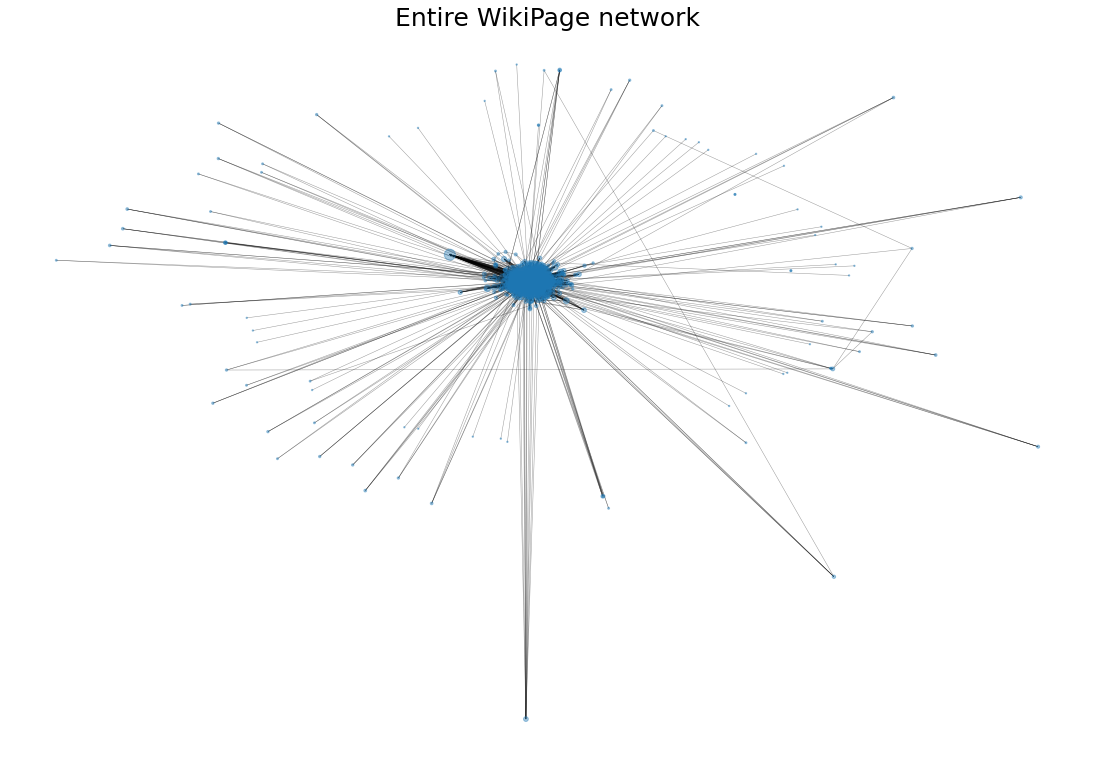

In [26]:
# Determining node sizes: 
node_sizes = [val*1500 for val in nx.degree_centrality(G).values()] 

# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        width=0.5, 
        alpha=0.4);

plt.title("Entire WikiPage network", fontsize=25, ha='center')
plt.show()

The entire WikiNetwork is clearly very sparse and the visualization is not meaningful at all. The network clearly needs work before anything meaningful can be interpreted visually. We will fix this later on. In the meantime, let's visualize only the nodes with at least 3 in-degree and 3 out-degree:

In [55]:
min_connectivity = 4
highly_connected_nodes = [node for node in G.nodes if G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]

G_high = G.subgraph(highly_connected_nodes)

print("Size of new highly connected subgraph: {}".format(len(G_high)))

Size of new highly connected subgraph: 377


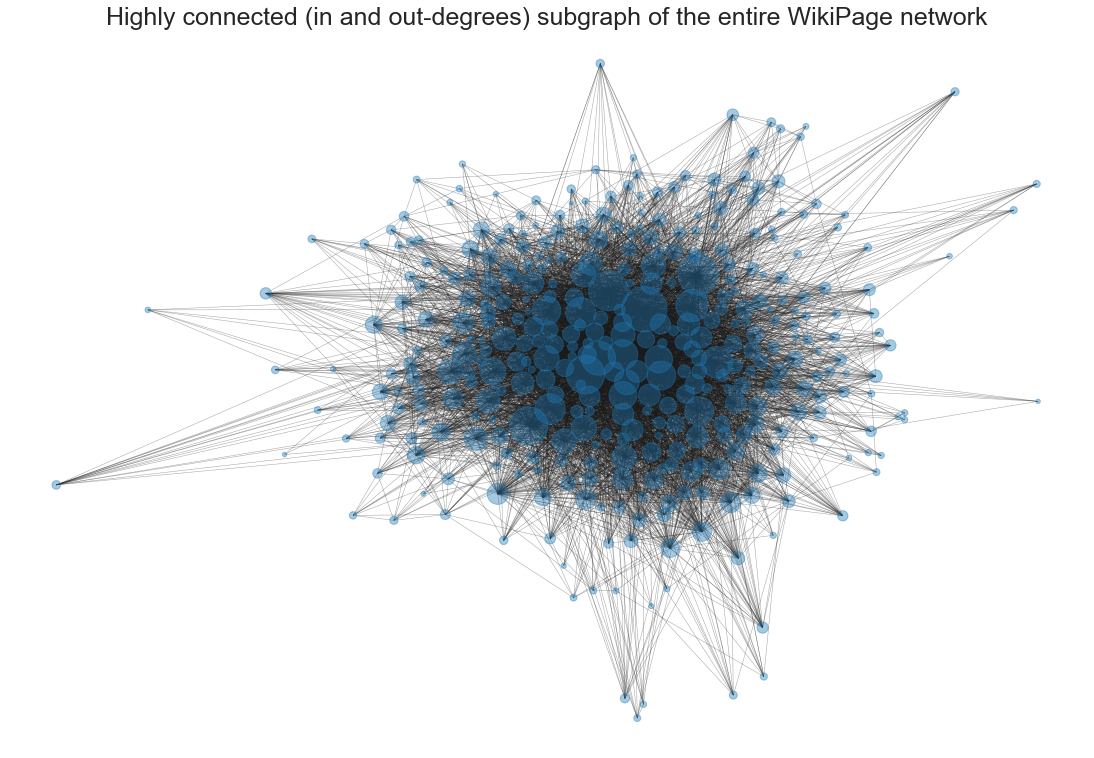

In [58]:
# Getting positions for the network nodes

positions_subgraph = forceatlas2.forceatlas2_networkx_layout(G_high, 
                                                    pos=None, 
                                                    iterations=2000);

# Determining node sizes: 
node_sizes = [val*1500 for val in nx.degree_centrality(G_high).values()] 

# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        width=0.5, 
        alpha=0.4);

plt.title("Highly connected (in and out-degrees) subgraph of the entire WikiPage network", fontsize=25, ha='center')
plt.show()

That looks more revealing. The network seems to include a giant component, but we'll get to that later. Now let's explore what kind of nodes the network holds.

**Let's visualize the different types of nodes in the data:**

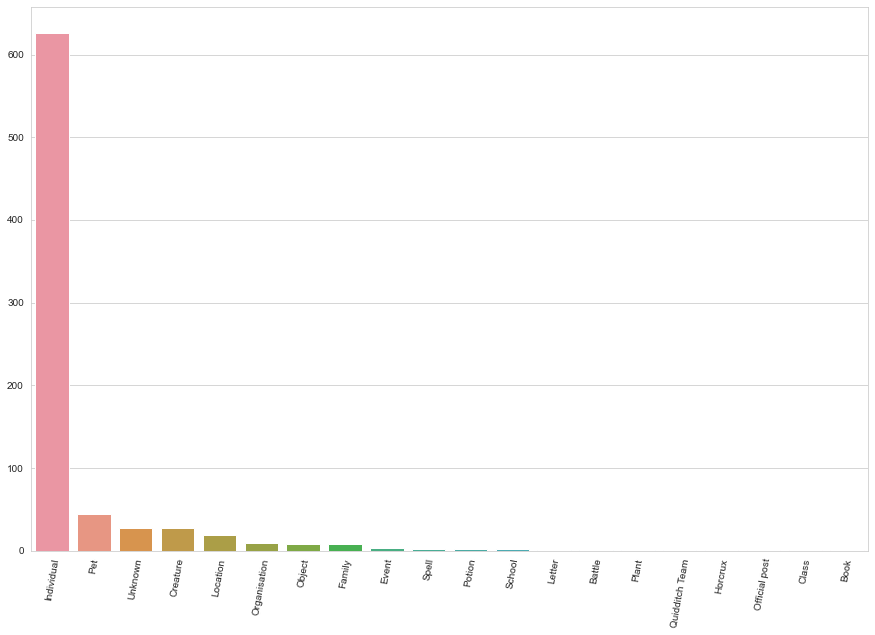

In [28]:
# Setting style
sns.set_style("whitegrid")

# Getting the types of WikiPages in the network
entity_types = [wiki_type for (node, wiki_type) in G.nodes.data('node_type')]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(entity_types).items(), 
                                             key=lambda item: item[1], reverse=True)}

# Preparing figure
plt.figure(figsize=(15,10))

# Plotting Wiki types
fig = sns.barplot(
    x = list(types.keys()),
    y = list(types.values())
)

plt.title("Frequency distribution of entity type in the whole Wiki network")
plt.xticks(rotation=80)

plt.show()

It would appear that thankfully, mostly our network consists of Individuals, with Pets following after that. This is good, because we're only interested in individuals for the remaining network analysis. 

Let's check the highest in-degree nodes in this whole network and see whether they're individuals

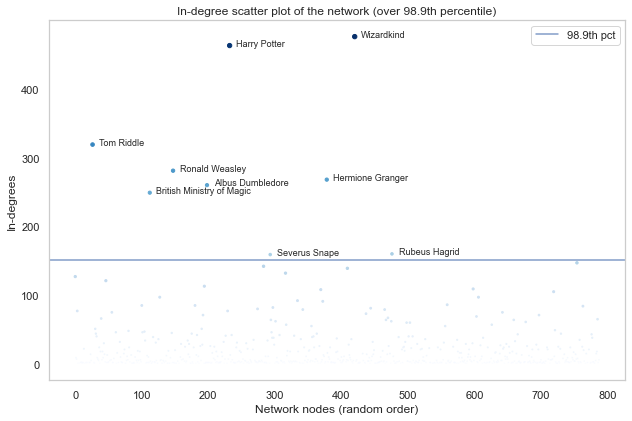

In [46]:
# Checking the highest in-degree nodes in the whole network

sns.set_style("whitegrid", {'axes.grid' : False})

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 98.9th percentile)", # Plot title 
                                         98.9 # percentile
                                        )

plt.show()

Notice above that even though our beloved Harry Potter characters populate the highest in-degree visualisation, the highest node is **Wizardkind**. Additionally, the **British Ministry of Magic** is included among the highest in-degree nodes. 

Although analyses could be interesting on a network like this, we need to change the network in such a way that only individuals are included:

**Now, let's determine the nodes that don't represent individuals:**

In [59]:
# Finding all nodes that aren't actual individuals
non_individual_nodes = [node for node in G.nodes if not G.nodes[node]['node_type'] == "Individual"] 

print("Size of entire Wiki network: {}".format(len(G)))

G.remove_nodes_from(non_individual_nodes)

print("Size of Wiki network after deletion of non-individuals: {}".format(len(G)))

Size of entire Wiki network: 788
Size of Wiki network after deletion of non-individuals: 626


The network now only consists of nodes that represent individuals. Now let's visualize this network much like we did previously, but now we can add colors representing node attributes!

In [61]:
min_connectivity = 3
highly_connected_nodes = [node for node in G.nodes if G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]

G_high = G.subgraph(highly_connected_nodes)

print("Size of new highly connected individuals subgraph: {}".format(len(G_high)))

Size of new highly connected individuals subgraph: 313


In [62]:
# Determining positions for the individuals

positions = forceatlas2.forceatlas2_networkx_layout(G_high, pos=None, iterations=2000);

In [63]:
# Determining node sizes: 

node_sizes = [val*1500 for val in nx.degree_centrality(G_high).values()] 

# Determining node colours

house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in G_high.nodes.data('house')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# Let's find the most connected nodes

top_nodes = dict(sorted(nx.degree_centrality(G_high).items(), key = operator.itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in G_high.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]

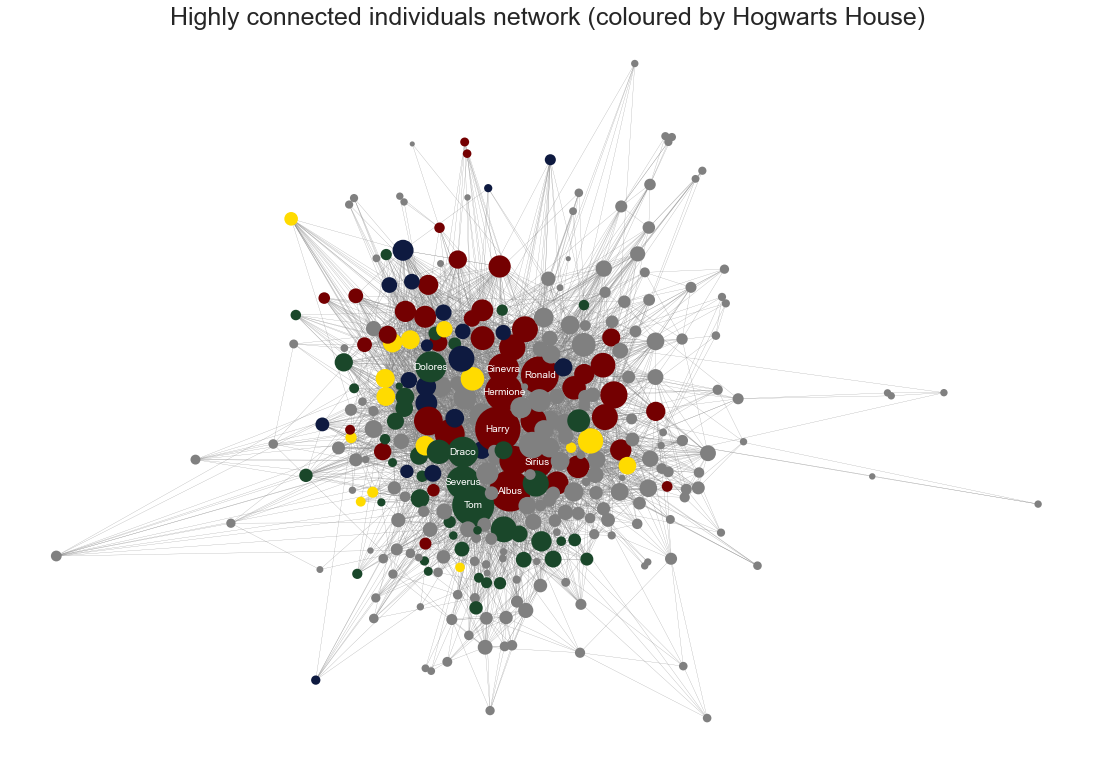

In [64]:
# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

The figure above shows the highly connected individuals in the network. The grey nodes indicate that the character has no Hogwarts house, while the coloured nodes indicate the house colour of the character. Notice that the highly connected characters are labeled.

There are other attributes to explore, namely _blood type_, _book number_ among others. Let's visualize this:

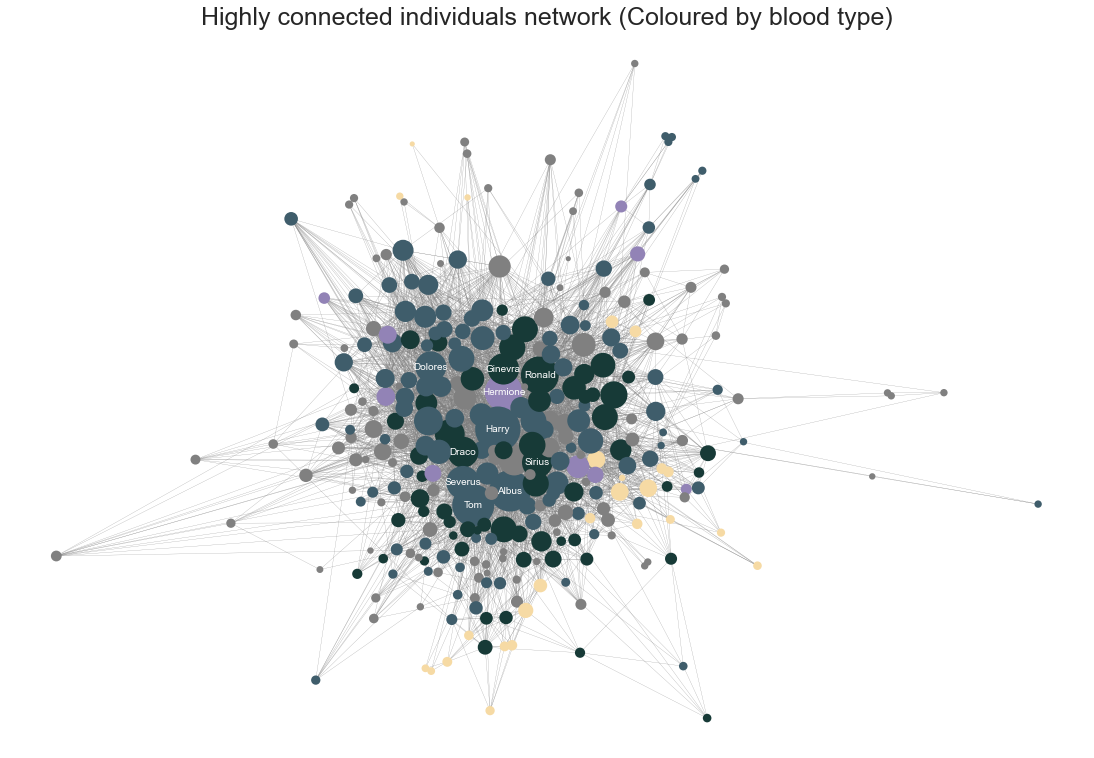

In [66]:
# Plotting by blood type

blood_colours = {
		'Pure-Blood' : '#173a37',
		'Half-Blood' : '#3f5d6b',
		'Muggle-Born' : '#9283b6',
		'Muggle' : '#f6daa4'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [blood_colours[blood] if blood in blood_colours else grey for (node, blood) in G_high.nodes.data('blood')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# And we're ready to visualise again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by blood type)", fontsize=25, ha='center')
plt.show()

_The network above shows the same network as before, but now nodes are coloured by Blood type. Beige is Muggle, purple is Muggle-born, blue is Half-blood and dark blue is Pure-blood._

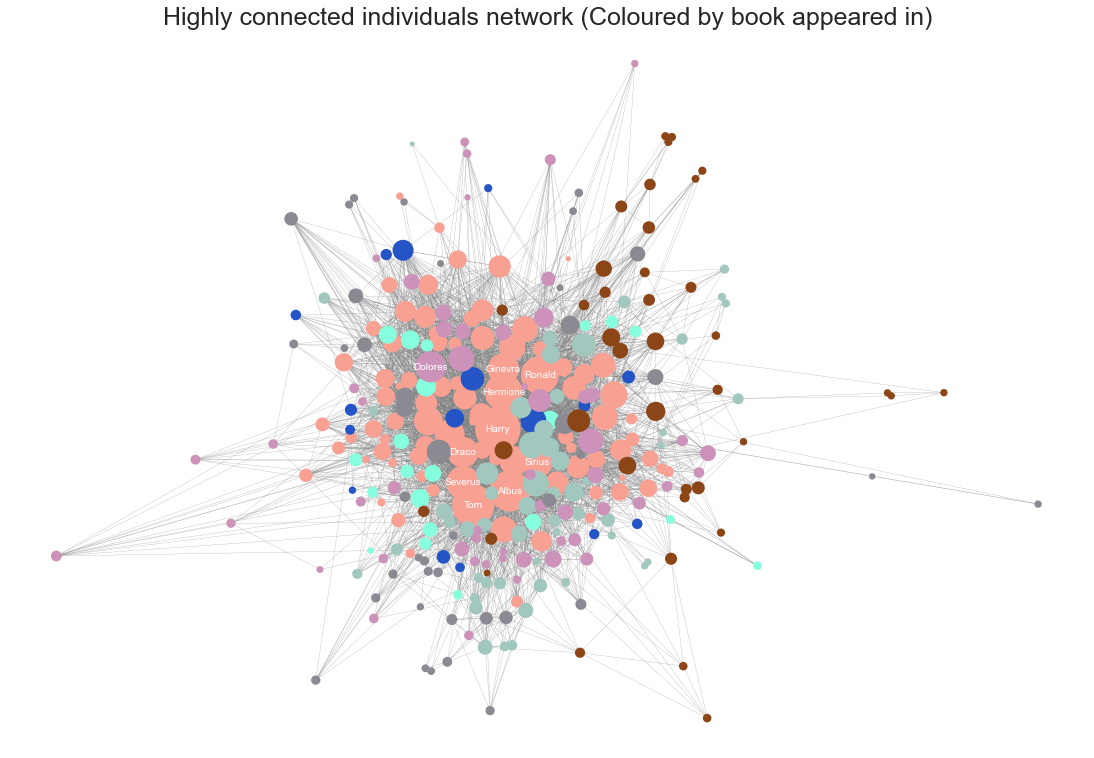

In [68]:
# Plotting by book number

book_colours = {
		1 : '#f8a193',
		2 : '#85ffdd',
		3 : '#2554c7',
		4 : '#a2c7bf',
		5 : '#cc92ba',
		6 : '#8b8991',
		7 : '#8b4516'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [book_colours[book] if book in book_colours else grey for (node, book) in G_high.nodes.data('book_nr')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# And we're ready to visualise once again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by book appeared in)", fontsize=25, ha='center')
plt.show()

_The network above shows the same network as before, but now nodes are coloured by Book number (the book the character first appeared in). The colours are fairly irrelevant, but notice how characters that are introduced in the same book tend to cluster together._

**Finally, let's visualise the network with only individuals with Hogwarts houses:**


In [78]:
min_connectivity = 3

nodes_with_houses = [node for node in G.nodes if G.nodes[node]['house'] != 'Unknown' and G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]


G_houses = G.subgraph(nodes_with_houses)

print("Size of new (houses only) individuals subgraph: {}".format(len(G_houses)))

Size of new (houses only) individuals subgraph: 124


In [81]:
# Setting house colour
node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in G_houses.nodes.data('house')]

# Let's find the most connected nodes again
top_nodes = dict(sorted(nx.degree_centrality(G_houses).items(), key = operator.itemgetter(1), reverse = True)[0:15])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in G_houses.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]
        

# Resetting sizes
node_sizes = [val*1500 for val in nx.degree_centrality(G_houses).values()] 

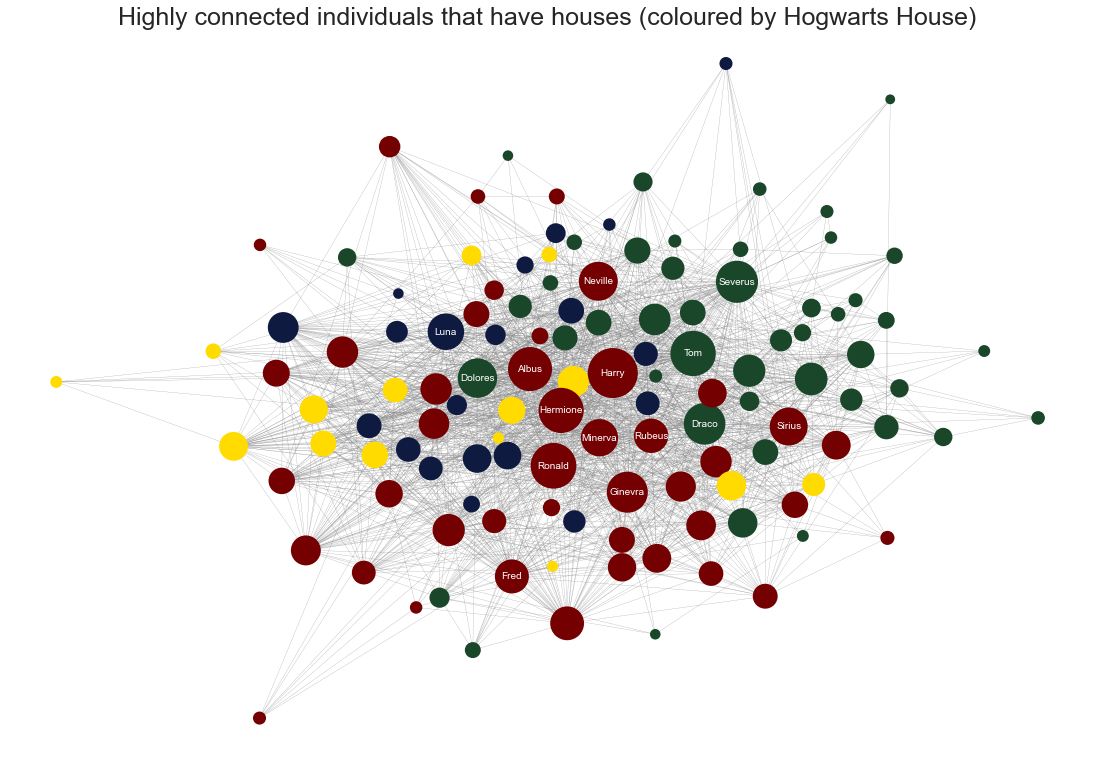

In [82]:
# positioning nodes

positions = forceatlas2.forceatlas2_networkx_layout(G_houses, 
                                                    pos=None, 
                                                    iterations=2000);

# And we're ready to visualise once again: 

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_houses), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_houses, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals that have houses (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

_It can be seen that the highly connected nodes with houses are actually not many compared to the whole Wiki network. Notice how the different houses tend to cluster together. This network includes most of the main characters of the Fandom universe! Notable characters are:_

* Harry
* Ron
* Hermione
* Snape (Severus)
* Hagrid (Rubeus)
* ...

TODO discuss the outcome of this analysis

---

<a id='3-1-2-networkanalyses'></a>
### 3.1.2 Wiki network statistics and analyses

TODO add text here


**Degree distribution analysis**

Let's explore the in-degree and out-degree distributions. The best way to do this is with a Histogram and a Log-log graph:

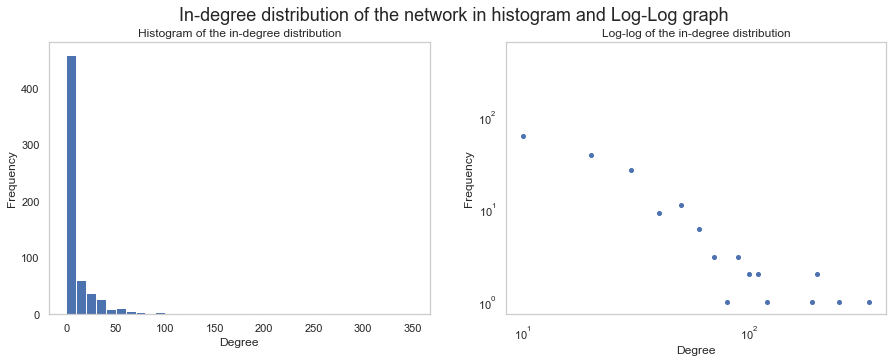

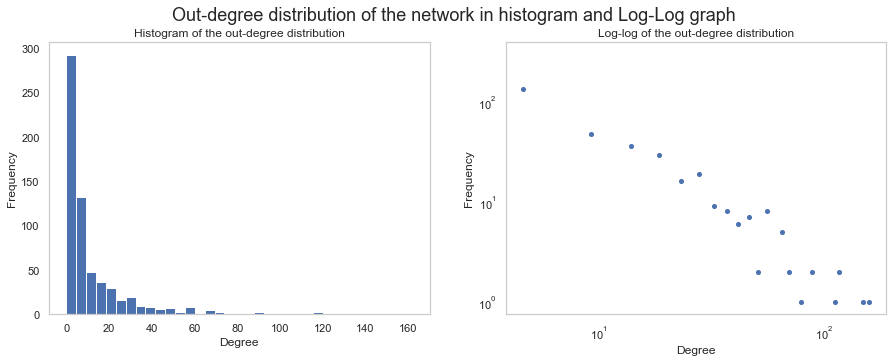

In [83]:
# Calling the predefined distribution visualisation functions

display_histogram_and_loglog_distributions(G_type=G.in_degree(), #Plotting the in-degree distribution
                                           bins=35, 
                                           print_str="in-degree", 
                                           title="In-degree distribution of the network in histogram and Log-Log graph")

display_histogram_and_loglog_distributions(G_type=G.out_degree(), # Plotting the out-degree distribution
                                           bins=35, 
                                           print_str="out-degree", 
                                           title="Out-degree distribution of the network in histogram and Log-Log graph")


The WikiPage network of individuals seems to show scale-free properties. It's very frequent to have little to no in-degrees, but the scale of in-degree distributions stretches fairly high. The out-degree distributions are more evenly distributed, with a few extremes as well. Notice that the in-degree scale streches more than double the length of the out-degree scale!

Now let's explore these distributions in scatter plots:

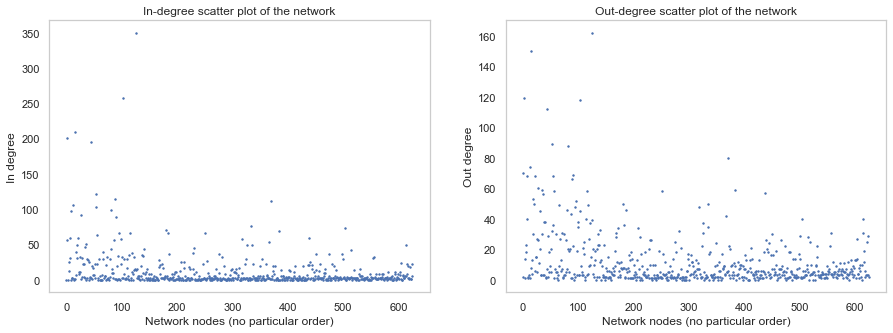

In [84]:
# Exploring the degree distributions through scatterplots

axs = make_scatter_plots(G)
plt.show()

It can clearly be seen from the figures above that the in-degree distribution tends to hover more around the bottom than in the out-degree distribution. Furthermore it looks like the out-degrees reach the same heights as the in-degrees, but that is because the scales are not equalized, let's account for this:

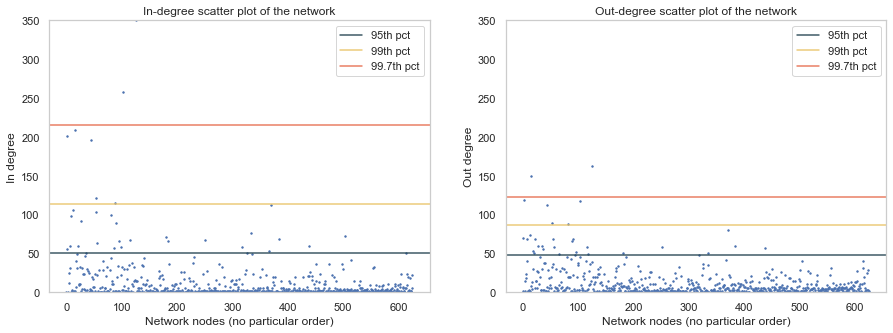

In [86]:
# Finding high percentiles in the degree distributions

axs = make_scatter_plots(G, 
                         with_percentiles = True, 
                         equalize_y_axis = True)

plt.show()

The figure above shows the in-, and out-degree distributions of the individuals network, with the scales equalized and high percentiles added. It's clear that as we have noted before, the in-degrees stretch higher than the out-degrees. Notice how the high percentile (99.7th) is much higher on the left graph.

Finally, let's explore which nodes are the highly connected ones in terms of in-, and out-degrees:

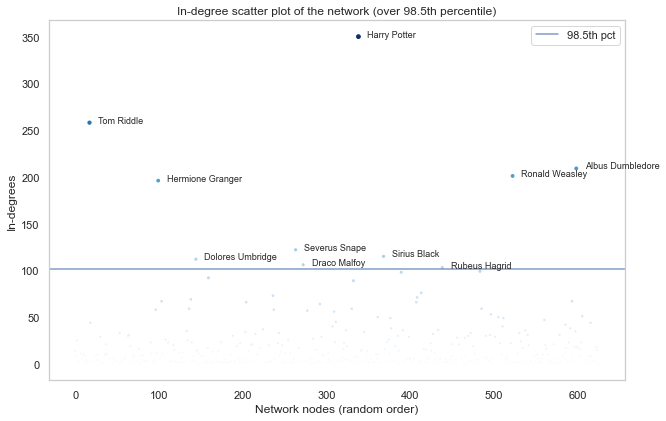

In [87]:
# Investigation of highest in-degree nodes: 

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 98.5th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

plt.show()

The figure above shows the high percentiles of in-degree distribution. All these characters are very well known and as such this should come as no surprise. Note that **Tom Riddle** here is also known as **Lord Voldemort** in the universe.

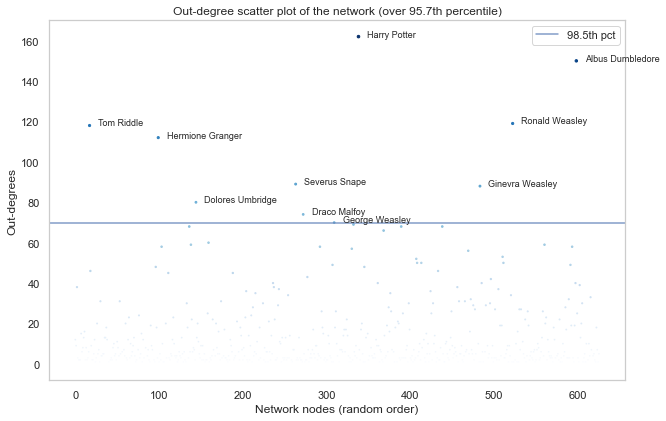

In [89]:
# Investigation of highest out-degree nodes:

plot_scatter_with_labels_over_percentile(out_degrees, 
                                         "Out-degrees", # Axis string
                                         "Out-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

As makes sense from a WikiPage network, the high-percentile out-degree nodes are very similar to the in-degree nodes. This means that these nodes had the most amount of links to other nodes in the network.

**Other analyses - Attribute statistics**

Let's explore what the frequencies of different attributes are in the network:

**Book number first appeared in:**

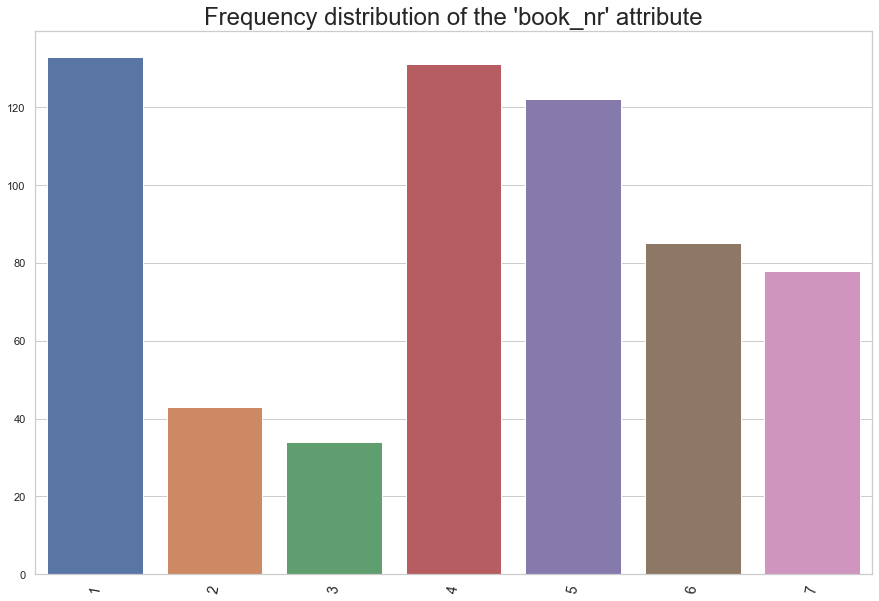

In [204]:
def plot_attribute(attribute, entity_types = False, comparing = False, disgarding_unknowns = False):
    # Setting style
    sns.set_style("whitegrid")

    # Getting the types of WikiPages in the network
    if not entity_types:
        entity_types = [book for (node, book) in G.nodes.data(attribute)]

    # Sorting the values by frequency
    types = {key: value for key, value in sorted(collections.Counter(entity_types).items(), 
                                                 key=lambda item: item[1], reverse=True)}

    # Preparing figure
    if not comparing:
        plt.figure(figsize=(15,10))
    else:
        plt.figure(figsize=(7,5))

    # Plotting Wiki types
    fig = sns.barplot(
        x = list(types.keys()),
        y = list(types.values())
    )

    plt.xticks(rotation=80, size=14)
    if disgarding_unknowns:
        plt.title("Frequency distribution of the '{}' attribute (disgarding unknown nodes)".format(attribute), 
                  fontdict = {'fontsize' : 24})
    else:
        if comparing:
            plt.title("Comparison between nodes that have known attribute '{}' vs those that do not".format(attribute), 
                  fontdict = {'fontsize' : 14})

        else:
            plt.title("Frequency distribution of the '{}' attribute".format(attribute), 
                  fontdict = {'fontsize' : 24})

    plt.show()

plot_attribute("book_nr")

TODO add text

**Character gender:**

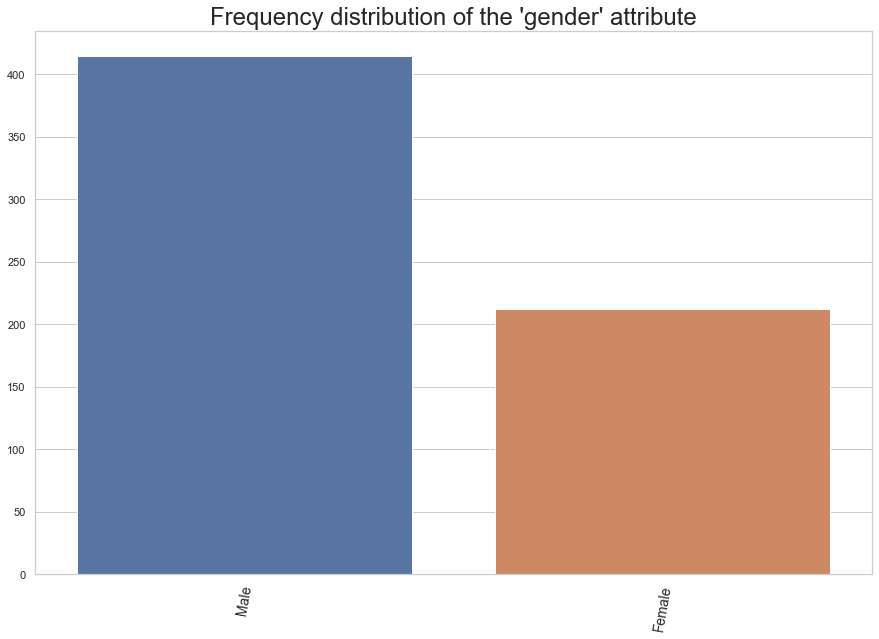

In [202]:
plot_attribute("gender")

TODO add text

**Character hair:**

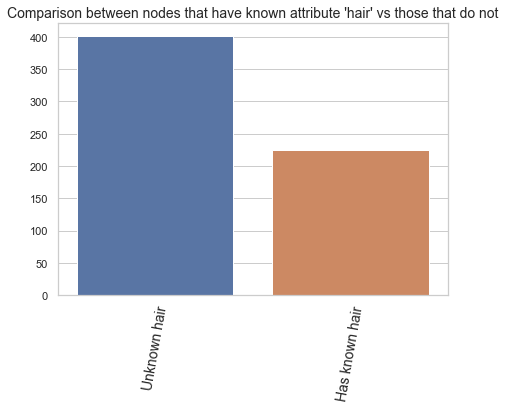

In [205]:
nodes_with_hair = ["Has known hair" if hair != "Unknown" else "Unknown hair" for (node, hair) in G.nodes.data('hair')]
plot_attribute("hair", nodes_with_hair, comparing=True)

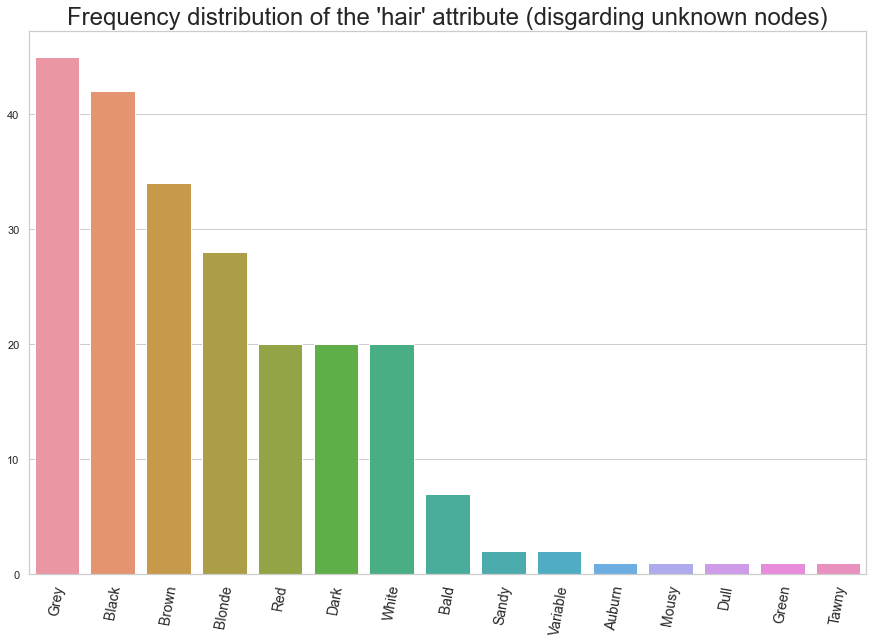

In [159]:
# Finding the hair values from the nodes
nodes_hair = [hair for (node, hair) in G.nodes.data('hair')]

nodes_hair_no_unknowns = [hair for hair in nodes_hair if hair != "Unknown"]

plot_attribute("hair", nodes_hair_no_unknowns, disgarding_unknowns=True)

TODO add text

**Character eyes:**

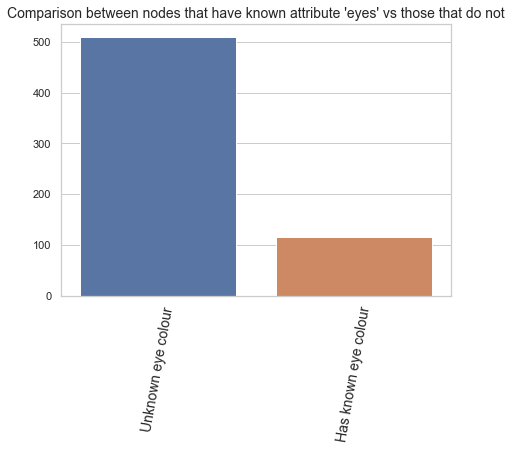

In [206]:
nodes_with_eyes = ["Has known eye colour" if eyes != "Unknown" else "Unknown eye colour" for (node, eyes) in G.nodes.data('eyes')]
plot_attribute("eyes", nodes_with_eyes, comparing=True)

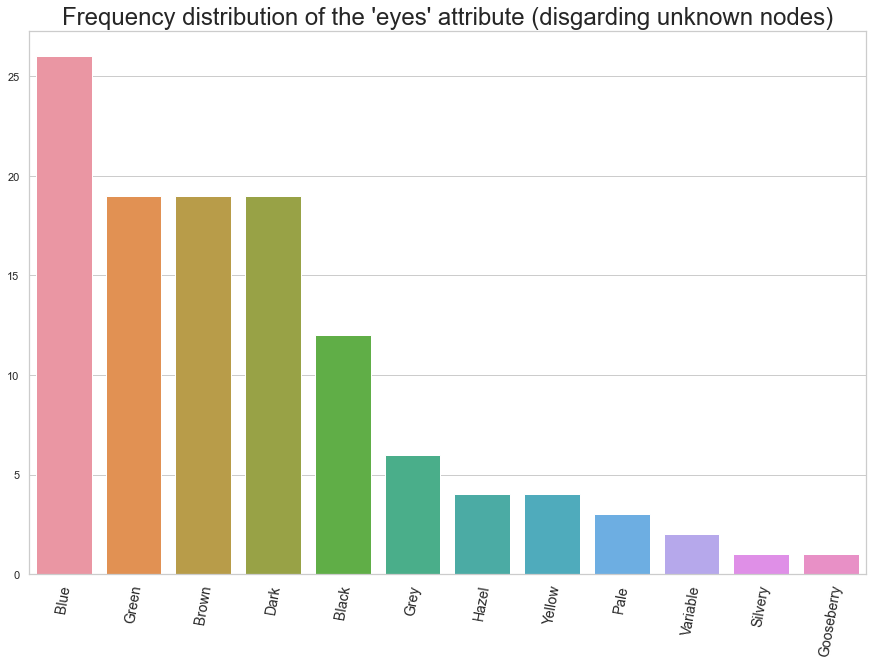

In [161]:
# Finding the hair values from the nodes
nodes_eyes = [eyes for (node, eyes) in G.nodes.data('eyes')]

nodes_eyes_no_unknowns = [eyes for eyes in nodes_eyes if eyes != "Unknown"]

plot_attribute("eyes", nodes_eyes_no_unknowns, disgarding_unknowns=True)

TODO add text

**Character species:**

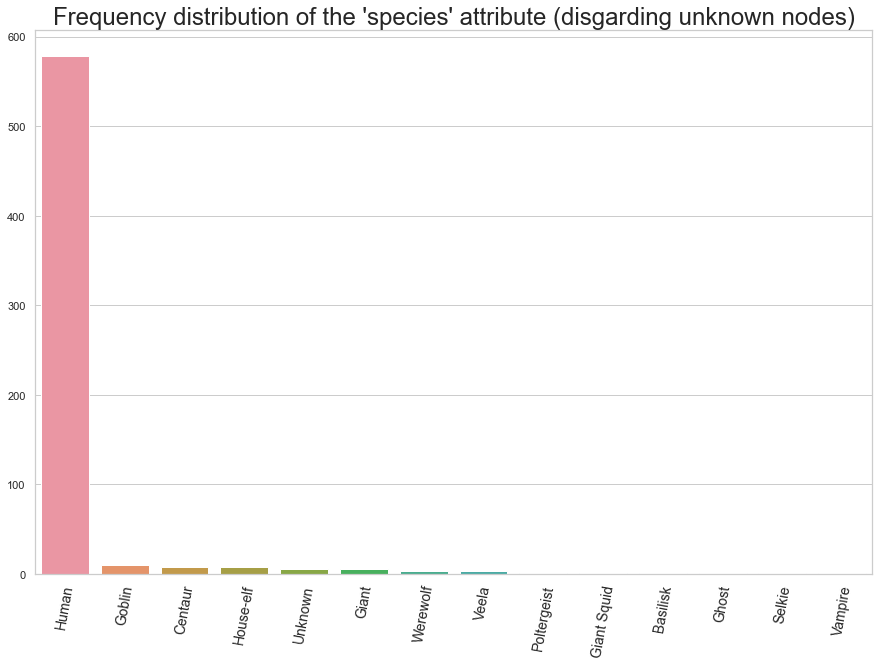

In [162]:
# Species

plot_attribute("species", disgarding_unknowns=True)

TODO add text

**Character nationality:**

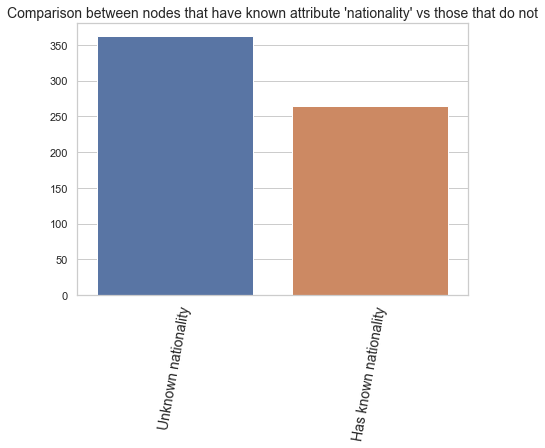

In [207]:
# Nationality

nodes_with_nationality = ["Has known nationality" if nation != "Unknown" else "Unknown nationality" for (node, nation) in G.nodes.data('nationality')]
plot_attribute("nationality", nodes_with_nationality, comparing=True)

TODO add text

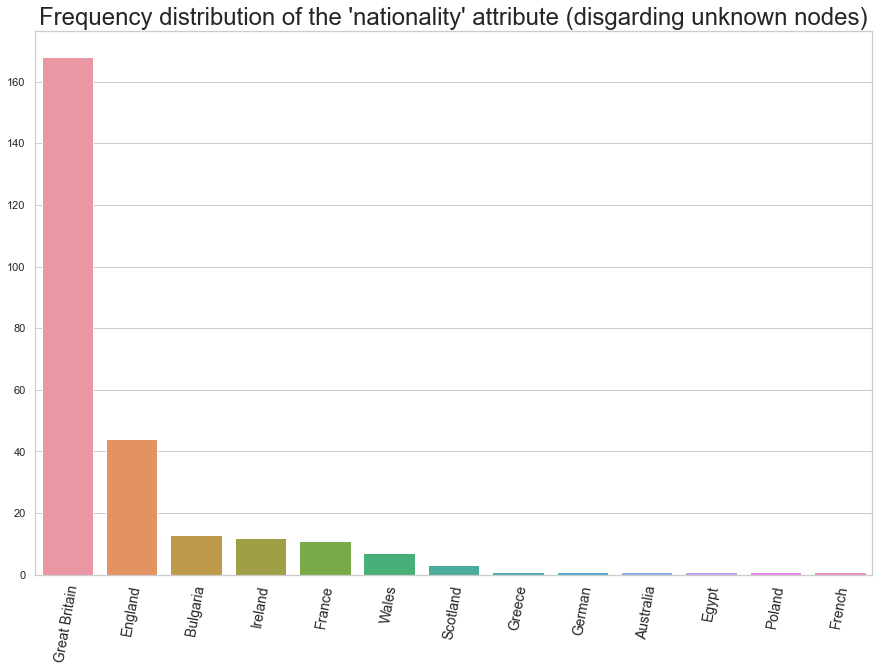

In [164]:
nodes_nations = [nation for (node, nation) in G.nodes.data('nationality')]

nodes_nations_no_unknowns = [nation for nation in nodes_nations if nation != "Unknown"]

plot_attribute("nationality", nodes_nations_no_unknowns, disgarding_unknowns=True)

TODO add text

Now that we've looked at some of the descriptive attributes of the dataset, we are taking a special look at the remaining two: **Hogwarts house** and **Blood type**. We're hypothesizing that we'll see some relationship between the two later on.

**Hogwarts house:**

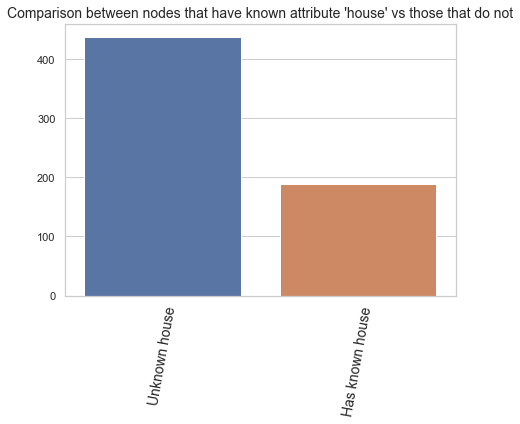

In [208]:
node_houses = ["Has known house" if house != "Unknown" else "Unknown house" for (node, house) in G.nodes.data('house')]
plot_attribute("house", node_houses, comparing=True)

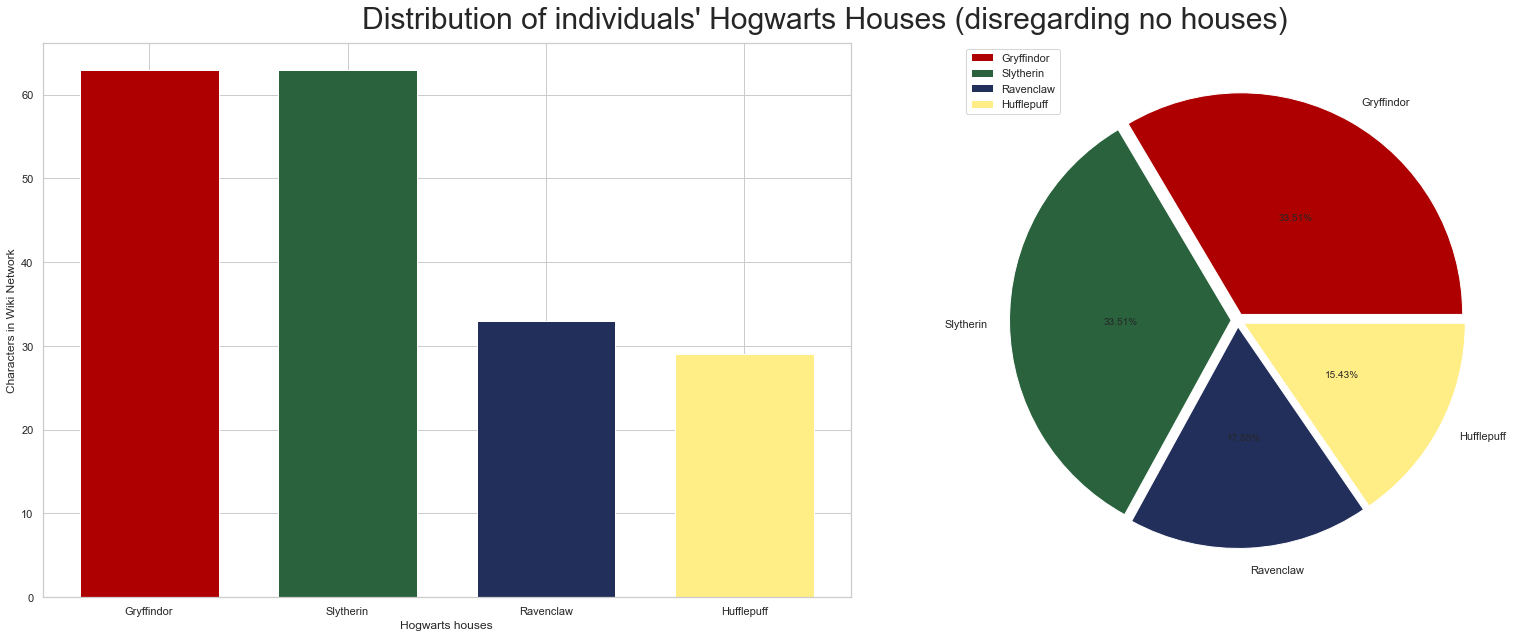

In [211]:
# Setting style
sns.set_style("whitegrid")


# Getting the houses of the individuals in the network
node_houses = [house for (node, house) in G.nodes.data('house')]
node_houses = [house for house in node_houses if house != "Unknown"]


# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_houses).items(), 
                                             key=lambda item: item[1], reverse=True)}

houses = list(types.keys())
frequencies = list(types.values())

color_set = ('#AE0001', '#2A623D', '#222F5B', '#FFED86')

labels = houses

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(houses, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Hogwarts houses")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

test = {
    "Hello": 55,
    "World": 25
}

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' Hogwarts Houses (disregarding no houses)", size=30)
fig.tight_layout()


TODO add text

**Blood types**

_Now let's explore what the distribution of blood types is in the Universe:_

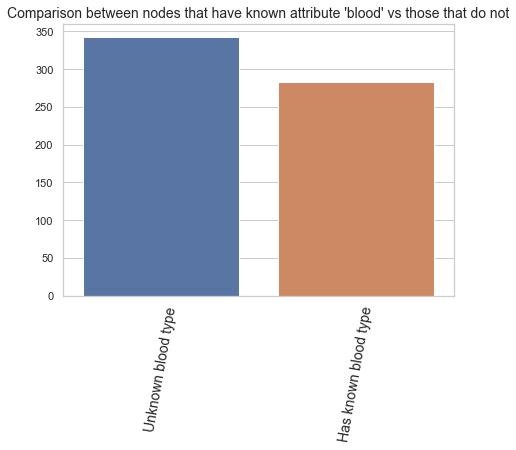

In [209]:
node_blood = ["Has known blood type" if blood != "Unknown" else "Unknown blood type" for (node, blood) in G.nodes.data('blood')]
plot_attribute("blood", node_blood, comparing=True)

_Unfortunately, it seems like there's a lot of missing data on blood types again. But we have almost 300 individuals with a noted blood type (or several, but that has been cleaned). Let's see the distribution:_

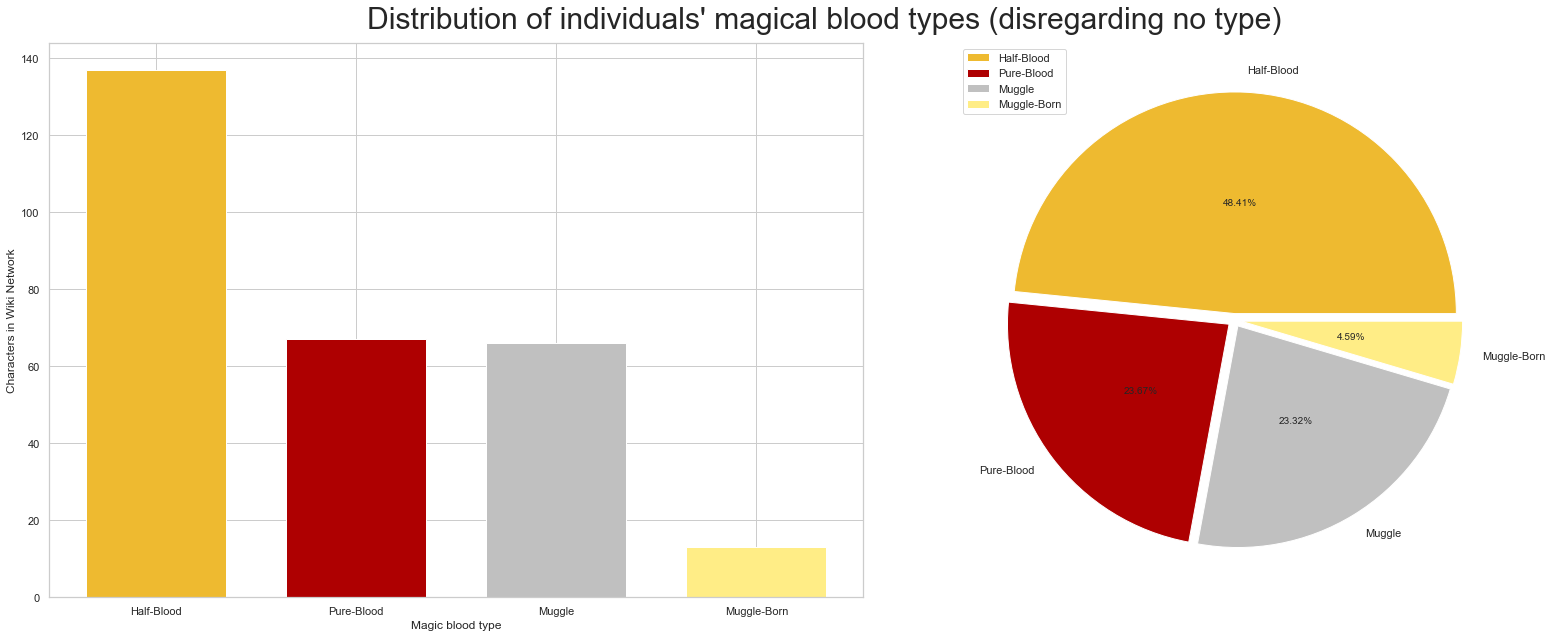

In [200]:
# Setting style
sns.set_style("whitegrid")

blood_types = ["Has blood type" if blood_type != "Unknown" else "Unknown blood type" for (node, blood_type) in G.nodes.data('blood')]

# Getting the blood types of the individuals in the network
node_blood_types = [blood_type for (node, blood_type) in G.nodes.data('blood')]
node_blood_types = [blood_type for blood_type in node_blood_types if blood_type != "Unknown"]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_blood_types).items(), 
                                             key=lambda item: item[1], reverse=True)}
blood_types = list(types.keys())
frequencies = list(types.values())

color_set = ('#EEBA30', '#AE0001', '#C0C0C0', '#FFED86')

labels = blood_types

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(blood_types, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Magic blood type")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' magical blood types (disregarding no type)", size=30)
fig.tight_layout()


The Harry Potter universe seems to be mostly populated by half-blood witches and wizards. Pure-bloods and Muggles are also common, with muggle-born witches and wizards being least common.

Now, let's look at **Blood types** by **houses**, and confirm whether our hypothesis that a relationship exists between the two is true. In particular, it's expected that **Slytherin** will have many **pure-bloods**, and less **muggle-born**.

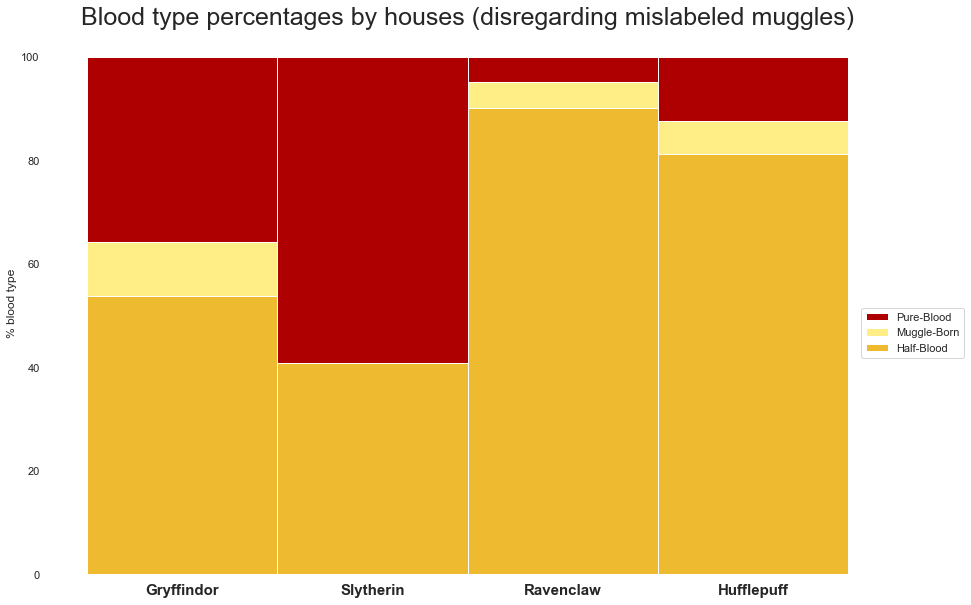

In [228]:
sns.set_style("whitegrid", {'axes.grid' : False})

# Fetching nodes that have a valid blood type
blood_type_nodes = [node if blood_type != "Unknown" else None for (node, blood_type) in G.nodes.data('blood')]

# Fetching nodes that have a valid house
house_nodes = [node if house != None else None for (node, house) in G.nodes.data('house')]

# Intersecting the two
blood_types_and_houses =  list(set(blood_type_nodes) & set(house_nodes))

# Declaring a dict to store the data
houses_by_blood_type = {
    "Pure-Blood": [0, 0, 0, 0],
    "Muggle": [0, 0, 0, 0],
    "Muggle-Born": [0, 0, 0, 0],
    "Half-Blood": [0, 0, 0, 0]
}

for i in range(len(houses)):
    curr_house = houses[i]
    for node in blood_types_and_houses: # looping through the nodes we know both have a house and blood type
        if node: # bug fix
            nd = G.nodes[node]
            if (nd['house']  == curr_house):
                blood_type = nd['blood']
                houses_by_blood_type[blood_type][i] += 1 # Setting blood type's house index to +1
                
plt.figure(figsize=(15,10))

# Defining same colour set as before for blood types
color_set = ('#AE0001', '#C0C0C0', '#FFED86', '#EEBA30')

# Setting the positions for the bars
x_positions = list(range(len(houses_by_blood_type)))

houses_by_blood_type['Muggle'] = [0, 0, 0, 0] # We don't want muggles, as they're mislabeled

# Getting the values for the houses for each blood type
pure_bloods = np.array(houses_by_blood_type['Pure-Blood'])
muggles = np.array(houses_by_blood_type['Muggle'])
muggle_born = np.array(houses_by_blood_type['Muggle-Born'])
half_bloods = np.array(houses_by_blood_type['Half-Blood'])

# Adding the arrays up to get the total amount of individuals by house
tot_individuals = pure_bloods + muggles + muggle_born + half_bloods

# Getting the percentages
pure_bloods = pure_bloods / tot_individuals * 100
muggles = muggles / tot_individuals * 100
muggle_born = muggle_born / tot_individuals * 100
half_bloods = half_bloods / tot_individuals * 100

# Plotting the actual bars
ax0 = plt.bar(x_positions, pure_bloods, bottom = muggles + muggle_born + half_bloods, edgecolor="White", width=1, label='Pure-Blood', color = color_set[0])
ax1 = plt.bar(x_positions, muggles, bottom = muggle_born + half_bloods, edgecolor="White", width=1, color = color_set[1])
ax2 = plt.bar(x_positions, muggle_born, bottom = half_bloods, edgecolor="White", width=1, label='Muggle-Born', color = color_set[2])
ax3 = plt.bar(x_positions, half_bloods, edgecolor="White", width=1, label='Half-Blood', color = color_set[3])

# Setting plot details
plt.xticks(x_positions, houses, fontweight='bold', size = 15)
#plt.xlabel("Hogwarts house")
plt.ylabel("% blood type")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.1, 0.5))
#plt.legend()
plt.title("Blood type percentages by houses (disregarding mislabeled muggles)", size = 25)
sns.despine(bottom = True, left = True)

plt.show()

The figure above shows the percentages of the different blood types between the different Hogwarts houses (disregarding a few mislabeled Muggles). Our hypothesis would seem to be true, with Slytherin having over half pure-bloods. Gryffindor also has a sizeable amount, with Ravenclaw and Hufflepuff having very few. 

It's worth noting here that the few muggles that were mislabeled were part of Slytherin, but were removed as that's a clear mislabel.

---

---

---

---

<a id='6-2-wiki-cleaning'></a>
## 6.1 Fandom WikiPages - data fetching and cleaning



In [2]:
# Defining home directory
hd = os.getcwd()
print("Home directory set:")
print(hd)

Home directory set:
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project


### Setup and preperation for data fetching

After inspecting the Fandom API, we came up with the character indexes we wanted to fetch based on the books that characters (and other things) appear in. Here, the first step is to define the URLS used to fetch the data, and get the links that correspond to the characters that appear in those books. Some manual labour was required to make the right API calls, and to filter out those links that were not relevant.

In [3]:
# Creating a list of all the wikilinks of characters and another list of in which book each character appeared first
wikilinks = []
book_nrs = []

books = ['Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)', 
'Harry_Potter_and_the_Chamber_of_Secrets_(character_index)', 
'Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)',
'Harry_Potter_and_the_Goblet_of_Fire_(character_index)',
'Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)',
'Harry_Potter_and_the_Half-Blood_Prince_(character_index)',
'Harry_Potter_and_the_Deathly_Hallows_(character_index)']

for book in books:

    # Get characters from each book
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    wikiresponse_list = urllib2.urlopen(baseurl+book) # generate the complete query url
    wikihtml_list = wikiresponse_list.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml_list) # Load the json 

    # Fetching the book text from json
    text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']

    # Extracting all the links from the text
    links = re.findall(r"\[\[(.*?)\]\]", text)
    
    # Cleaning the links
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    
    # Determining book number
    book_nr = [books.index(book)+1 for i in range(len(set(links_clean)))]
    
    # Adding indication which book the character first appeared in
    wikilinks.extend(set(links_clean))
    book_nrs.extend(book_nr)

The resulting pages were then inserted to a DataFrame and duplicates were dropped.

In [4]:
# Creating a dataframe for wikis and their respective book numbers

df_wiki = pd.DataFrame(list(zip(wikilinks,book_nrs)), columns=['wiki','book'])
print("Dataframe length before dropping duplicates: {}".format(len(df_wiki)))

# We have a few duplicates that we need to drop. 
# We like to keep the first instance where the characters appeared
df_wiki = df_wiki.drop_duplicates(subset=['wiki'], keep='first')
print("Dataframe length after dropping duplicates: {}".format(len(df_wiki)))

Dataframe length before dropping duplicates: 810
Dataframe length after dropping duplicates: 789


### Fetching WikiPages

Now that the dataframe was set up, we fetched the pages from the Fandom API. We also had to handle redirects and make sure we were storing the correct data. The pages are stored in their respective book's folders (book1 - book7), as text files. 

Here, the folder structure of the project was heavily utilised, with each WikiPage stored in a .txt file within a respective 'book' folder. The reason this cell takes a while to run is because it needs to call the API for each character in our dataframe.

In terms of fetching the WikiPages, some error handling and regular expressions were used. Most notably, redirects were handled in the loop by visiting the page being pointed to, and alternative WikiPages are caught and stored, if applicable.

In [5]:
# Defining the working directory

os.chdir(hd + "/Wikis")
wd = os.getcwd()

# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Now we must loop through all the character wikis and download all of their text into files
folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)
        
# Keep information about which links redirect -> 
# That way we can make sure the information is displayed as correctly as possible
df_wiki['alternative_wiki'] = None

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd + '/book' + str(row['book'])
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Get info about the character
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    title = urllib.parse.quote(row.wiki)
    file_name = row.wiki

    print("Book: ", row.book, " Character: ", row.wiki)

    wikiresponse = urllib2.urlopen(baseurl+title) # generate the complete query url
    wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml) # Load the json 

    # Extract the page text from the json, these are located at different places 
    try:
        text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
    except:
        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
        except:
            if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                text = ''
   
    # Before we continue we must check if there is a redirect on the text - otherwise we will get no info on the character
    if text.startswith('#REDIRECT'):
        
        link = re.findall(r"\[\[(.*?)\]\]", text)
        new_title = urllib.parse.quote(link[0])
        print("WAS REDIRECTED TO: ", link[0])

        #Redo the steps above with the new_title
        wikiresponse = urllib2.urlopen(baseurl+new_title) # generate the complete query url
        wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
        wikijson = json.loads(wikihtml) # Load the json

        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
        except:
            try:
                text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
            except:
                if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                    text = ''

        # Update the wiki redirects to
        df_wiki.at[idx, 'alternative_wiki'] = link[0]
        file_name = link[0]

    # Create a txt file of the text contained on the wikipage
    file = open(file_name + '.txt', "w") 
    file.write(text) 
    file.close() 

# going back to home directory
os.chdir(hd)

Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book1
Book:  1  Character:  Battle in the Philosopher's Stone Chambers
WAS REDIRECTED TO:  Skirmish in the Underground Chambers
Book:  1  Character:  Adalbert Waffling
Book:  1  Character:  Norberta
Book:  1  Character:  Vernon Dursley's secretary
Book:  1  Character:  Quentin Trimble
Book:  1  Character:  Hogwarts Giant Squid
Book:  1  Character:  Baruffio
Book:  1  Character:  Sirius Black
Book:  1  Character:  Emeric Switch
Book:  1  Character:  King's Cross Station
Book:  1  Character:  Gregory the Smarmy
Book:  1  Character:  Garrick Ollivander
Book:  1  Character:  Angelina Johnson
Book:  1  Character:  Dudley Dursley's tortoise
Book:  1  Character:  Harry Potter
Book:  1  Character:  Lucius Malfoy
Book:  1  Character:  Poppy Pomfrey
Book:  1  Character:  McKinnon family
Book:  1  Character:  Hogwarts Express conductor
Book:  1  Character:  C

Book:  2  Character:  Ogden
Book:  2  Character:  Chudley Cannons
Book:  2  Character:  Transylvania
Book:  2  Character:  Veronica Smethley
Book:  2  Character:  Colin Creevey
Book:  2  Character:  Hetty Bayliss
Book:  2  Character:  Hogwarts Board of Governors
Book:  2  Character:  Fawkes
Book:  2  Character:  Salazar Slytherin
Book:  2  Character:  Fire Dwelling Salamander
Book:  2  Character:  Mason
Book:  2  Character:  Weasley family ghoul
Book:  2  Character:  Rowena Ravenclaw
Book:  2  Character:  Mason's wife
Book:  2  Character:  Hermione Granger's mother
Book:  2  Character:  Blood-Sucking Bugbear
Book:  2  Character:  Mosag
Book:  2  Character:  Manager of Flourish and Blotts
Book:  2  Character:  Mudblood
Book:  2  Character:  Bandon Banshee
Book:  2  Character:  Parseltongue
Book:  2  Character:  Godric Gryffindor
Book:  2  Character:  Tom Riddle's diary
WAS REDIRECTED TO:  T. M. Riddle's Diary
Book:  2  Character:  Yeti
Book:  2  Character:  Fawcett
Book:  2  Character: 

Book:  4  Character:  Ludovic Bagman's goblin creditors
Book:  4  Character:  Winky
Book:  4  Character:  Weird Sisters
Book:  4  Character:  Owen Cauldwell
Book:  4  Character:  Otto Bagman
Book:  4  Character:  Kevin
Book:  4  Character:  Unidentified female Chinese Fireball
Book:  4  Character:  Lee Jordan's father
Book:  4  Character:  Lev Zograf
Book:  4  Character:  Andorran Ministry of Magic
Book:  4  Character:  Alastor Moody
Book:  4  Character:  Alice Longbottom
Book:  4  Character:  Dennis Creevey
Book:  4  Character:  Thomas Riddle
Book:  4  Character:  Summers
Book:  4  Character:  Ogg
Book:  4  Character:  Aberforth Dumbledore
Book:  4  Character:  Mulciber (Marauder-era)
WAS REDIRECTED TO:  Mulciber II
Book:  4  Character:  Vasily Dimitrov
Book:  4  Character:  Bartemius Crouch Junior
Book:  4  Character:  Igor Karkaroff
Book:  4  Character:  Bodrod the Bearded
Book:  4  Character:  Cornelius Fudge's wife
Book:  4  Character:  Dot
Book:  4  Character:  Bartemius Crouch J

Book:  6  Character:  Amy Benson
Book:  6  Character:  Sanguini
Book:  6  Character:  Mulciber (Riddle-era)
WAS REDIRECTED TO:  Mulciber I
Book:  6  Character:  Morfin Gaunt
Book:  6  Character:  Montgomery sisters
Book:  6  Character:  Caractacus Burke
Book:  6  Character:  Eric Whalley
Book:  6  Character:  Katie Bell's father
Book:  6  Character:  Eloise Midgen's father
Book:  6  Character:  Corban Yaxley
Book:  6  Character:  Chancellor of the Exchequer
Book:  6  Character:  Rupert Brookstanton
Book:  6  Character:  Rosalind Bungs
Book:  6  Character:  Cormac McLaggen
Book:  6  Character:  Romilda Vane
Book:  6  Character:  Unidentified nine-year old's grandparents
Book:  6  Character:  Avery (Riddle-era)
WAS REDIRECTED TO:  Avery I
Book:  6  Character:  Horace Slughorn
Book:  6  Character:  Urquhart
Book:  6  Character:  Wilkie Twycross
Book:  6  Character:  Prime Minister's niece
Book:  6  Character:  Damocles Belby
Book:  6  Character:  Alecto Carrow
Book:  6  Character:  Dirk C

In [6]:
# Showing how the dataframe looks now
df_wiki.head(3)

,wiki,book,alternative_wiki
0,Battle in the Philosopher's Stone Chambers,1,Skirmish in the Underground Chambers
1,Adalbert Waffling,1,None
2,Norberta,1,None


Here, checking on alternative wikis is necessary. Let's see which are in the dataframe:

In [7]:
# If the redirect links already exist in the dataframe we need to drop them

alternative_wikis = set(list(df_wiki.alternative_wiki))
df_wiki[df_wiki.wiki.isin(alternative_wikis)]

,wiki,book,alternative_wiki
417,Alastor Moody,4,None


In [8]:
# Seems like Alastor Moody is also Alastor "Mad-Eye" Moody in the data

# So we override the alternative_wiki link for this row 
df_wiki[df_wiki.wiki == 'Alastor Moody']['alternative_wiki'] = 'Alastor "Mad-Eye" Moody'

#Finally we drop the row containing 'Alastor "Mad-Eye" Moody' in the wiki
df_wiki = df_wiki[df_wiki.wiki != 'Alastor "Mad-Eye" Moody']

If we were to overwrite the already existing data with this fetch we would run the following cell, but to avoid this we leave it commented:

In [9]:
# Switching back to Wikis folder
#os.chdir(hd + "/Wikis")

# Creating a new folder to store the dataframe and switching to it:
#if not os.path.exists("dataframes"):
#    os.mkdir("dataframes")
#os.chdir(hd + "/dataframes")

# And fetching the files is done, saving the dataframe:
#with open('original_wiki_df.pkl', 'wb') as f:
#    pickle.dump(df_wiki, f)

### Cleaning and sorting WikiPages

Now that all the files were downloaded, we needed to extract the valuable information out of them. This was a crucial step to be able to construct a network out of the data. 

We started by loading the original dataframe created by the steps above, as we wanted to avoid overwriting it. A new, cleaned dataframe will be created and stored.

In [10]:
# Start by fetching the dataframe from above and changing the directory:

os.chdir(hd + "/Wikis")

# Fetching the original dataframe

with open('dataframes/original_wiki_df.pkl', 'rb') as f:
    df_wiki = pickle.load(f)

Now, we looped through the DataFrame that contained information about the WikiPages, and opened the files that corresponded with the rows. Then, we fetched the links that were contained in the page, and various attributes such as the Hogwarts House, family and others.

This part required a lot of regular expression, template searching and cleaning. After a lot of work, a consistent method to extract page type, Hogwarts house etc. was found, and used to store data on the page. When extracting the templates to access the test, the Python package [MyParserFromHell](https://pypi.org/project/mwparserfromhell/) came in particularly handy.

In [11]:
# Now we need to loop through all the files and extract information to add to the dataframe

# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None

folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']

# Define the working directory
wd = hd + ("/Wikis")

# Add columns to the dataframe for the additional information
df_wiki['text'] = None
df_wiki['links'] = None
df_wiki['house'] = "Unknown"
df_wiki['type'] = "Unknown"
df_wiki['blood'] = "Unknown"
df_wiki['nationality'] = "Unknown"
df_wiki['gender'] = "Unknown"
df_wiki['hair'] = "Unknown"
df_wiki['eyes'] = "Unknown"
df_wiki['species'] = "Unknown"


# Definitions for later
wiki_links = list(df_wiki.wiki)
alternative_links = list(df_wiki.alternative_wiki[df_wiki.alternative_wiki.notna()])
all_wiki_links = wiki_links + alternative_links

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd + '/book' + str(row['book'])
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Check if there was an alternative link for this character
    file_name = row.wiki
    if row.alternative_wiki != None:
        file_name = row.alternative_wiki

    # Opening the file containing the WikiPage
    file = open(file_name + '.txt', "r") 
    text = file.read()
    file.close() 

    # Print info so easier to see where loop is running
    #print("Book: ", row.book, " Character: ", file_name)

    # Finding the links in the entity's WikiPage
    links = re.findall(r"\[\[(.*?)\]\]", text)
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    
    # filter all the links based on characters in the dataframe
    wiki_links_clean = [l for l in links_clean if l in wiki_links]
    alternative_links_clean = [l for l in links_clean if l in alternative_links]

    # Clean up and overwrite link values where there are alternative wikis
    for i in range(len(alternative_links_clean)):
        alternative_links_clean[i] = df_wiki[df_wiki.alternative_wiki==alternative_links_clean[i]].wiki.item()

    # Combine both links into a single set
    clean_links = list(set(wiki_links_clean + alternative_links_clean))

    # Storing the WikiPage text and its links in the DataFrame
    df_wiki.at[idx, "text"] = text
    df_wiki.at[idx, "links"] = clean_links

    # We also want to extract more information from the text of each character.
    # Source for info: https://github.com/earwig/mwparserfromhell
    wikicode = mwparserfromhell.parse(text) # Convert to wikicode
    templates = wikicode.filter_templates() # Extract the templates of the wikicode

    # Checking whether the WikiPage is for an individual
    if len([t for t in templates if t.startswith('{{Individual infobox')]) > 0:
        
        # If the WikiPage is for an individual, we can start fetching information about the individual
        template = [t for t in templates if t.startswith('{{Individual infobox')][0] # Find the template containing the infobox

        # Extract the relevant information from the template
        if template.has_param('blood'):
            blood = re.findall(r"\[\[(.*?)\]\]", str(template.get('blood').value))

        if template.has_param('nationality'):
            nationality = re.findall(r"\[\[(.*?)\]\]", str(template.get('nationality').value))
            nationality = [n.split('|')[0] for n in nationality]

        if template.has_param('species'):
            species = re.findall(r"\[\[(.*?)\]\]", str(template.get('species').value))

        if template.has_param('gender'):
            gender = [template.get('gender').value.strip().split('<')[0]]

        if template.has_param('hair'):
            hair = [template.get('hair').value.strip().split('<')[0]]

        if template.has_param('eyes'):
            eyes = [template.get('eyes').value.strip().split('<')[0]]
  
        if template.has_param('house'):
            house = re.findall(r"\[\[(.*?)\]\]", str(template.get('house').value))
            
        # Write the relevant values into the dataframe
        if len(nationality) > 0:
            df_wiki.at[idx, "nationality"] = nationality[0]

        if len(species) > 0:
            if species[0] and species[0]:
                df_wiki.at[idx, "species"] = species[0]
            
        if len(gender) > 0:
            if gender[0] != "":
                df_wiki.at[idx, "gender"] = gender[0]
            
        if len(hair) > 0:
            if hair[0] != "":
                df_wiki.at[idx, "hair"] = hair[0]
            
        if len(eyes) > 0:
            if eyes[0] != "":            
                df_wiki.at[idx, "eyes"] = eyes[0]
                        
        if len(house) > 0:
            df_wiki.at[idx, "house"] = house[0]
            
        if len(blood) > 0:
            df_wiki.at[idx, "blood"] = blood
        
        # Finally, we're declaring the character as an individual
        df_wiki.at[idx, "type"] = "Individual"
    

    # If the WikiPage is not for an individual, here we store what type the entity is    
    elif len([t for t in templates if t.startswith('{{Object infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Object"
        
    elif len([t for t in templates if t.startswith('{{Pet individual infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Pet"
        
    elif len([t for t in templates if t.startswith('{{Creature infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Creature"
        
    elif len([t for t in templates if t.startswith('{{Letter_infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Letter"      

    elif len([t for t in templates if t.startswith('{{Family infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Family"      

    elif len([t for t in templates if t.startswith('{{Location infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Location"
        
    elif len([t for t in templates if t.startswith('{{Battle infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Battle" 

    elif len([t for t in templates if t.startswith('{{Quidditch Team infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Quidditch Team" 
        
    elif len([t for t in templates if t.startswith('{{Organisation infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Organisation" 
        
    elif len([t for t in templates if t.startswith('{{Potion infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Potion" 
        
    elif len([t for t in templates if t.startswith('{{Plant infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Plant" 
        
    elif len([t for t in templates if t.startswith('{{Spell infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Spell" 
    
    elif len([t for t in templates if t.startswith('{{Event infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Event" 
        
    elif len([t for t in templates if t.startswith('{{Official post')]) > 0:
        df_wiki.at[idx, "type"] = "Official post" 
        
    elif len([t for t in templates if t.startswith('{{School infobox')]) > 0 or len([t for t in templates if t.startswith('{{School_infobox')]) > 0:
        df_wiki.at[idx, "type"] = "School" 
        
    elif len([t for t in templates if t.startswith('{{Horcrux infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Horcrux" 
        
    elif len([t for t in templates if t.startswith('{{Class infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Class" 
        
    elif len([t for t in templates if t.startswith('{{Book infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Book" 
        
    else:
        df_wiki.at[idx, "type"] = "Unknown"
    
# reset wd
os.chdir(wd)


Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book1
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book2
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book3
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book4
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book5
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book6
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_0280

Now that every page was saved with appropriate attributes, cleaning was needed on the attributes:

**Blood**: For this part, a decision had to be made. Take for example Pius Thicknesse:

In [12]:
df_wiki[df_wiki.wiki == 'Pius Thicknesse']

,wiki,book,alternative_wiki,text,links,house,type,blood,nationality,gender,hair,eyes,species
805,Pius Thicknesse,7,None,{{FA}}\n{{Individual infobox\n|theme = mom\n|i...,"[Diagon Alley, Amycus Carrow, Rufus Scrimgeour...",Unknown,Individual,"[Pure-blood, half-blood]",Great Britain,Male,Black and silver,Unknown,Human


Their blood type is set as both Pure-blood and half-blood. This sort of mess was true throughout the dataframe, and as such the following decision was made for simplicity: 

**TODO describe decision here**

In [13]:
for idx, row in df_wiki.iterrows():
    if row.blood:
        blood = [x.lower() for x in row.blood]
        if 'half-blood' in blood:
            df_wiki.at[idx, 'blood'] = "Half-Blood"
        elif 'pure-blood' in blood:
            df_wiki.at[idx, 'blood'] = "Pure-Blood"
        elif 'non-magic people|muggle' in blood:
            df_wiki.at[idx, 'blood'] = "Muggle"
        elif 'muggle-born' in blood:
            df_wiki.at[idx, 'blood'] = "Muggle-Born"
        else:
            df_wiki.at[idx, 'blood'] = "Unknown"
    else:
        df_wiki.at[idx, 'blood'] = "Unknown"

In [14]:
df_wiki[df_wiki.wiki == 'Pius Thicknesse']

,wiki,book,alternative_wiki,text,links,house,type,blood,nationality,gender,hair,eyes,species
805,Pius Thicknesse,7,None,{{FA}}\n{{Individual infobox\n|theme = mom\n|i...,"[Diagon Alley, Amycus Carrow, Rufus Scrimgeour...",Unknown,Individual,Half-Blood,Great Britain,Male,Black and silver,Unknown,Human


As can be seen above, Pius is now Half-blood.

In [15]:
# Cleaning eyes attribute

for idx, row in df_wiki.iterrows():
    if row.eyes:
        eyes = row.eyes.lower()
        if 'blue' in eyes:
            df_wiki.at[idx, 'eyes'] = "Blue"
        if 'pale' in eyes:
            df_wiki.at[idx, 'eyes'] = "Pale"
        if 'green' in eyes:
            df_wiki.at[idx, 'eyes'] = "Green"            
        if 'brown' in eyes:
            df_wiki.at[idx, 'eyes'] = "Brown"
        if 'dark' in eyes:
            df_wiki.at[idx, 'eyes'] = "Dark"   
        if 'yellow' in eyes:
            df_wiki.at[idx, 'eyes'] = "Yellow"
        if 'gimlet' in eyes:
            df_wiki.at[idx, 'eyes'] = "Unknown"            
    else:
        df_wiki.at[idx, 'eyes'] = "Unknown"

**Hair**: Cleaning hair attribute:

In [16]:
# Cleaning hair attribute

for idx, row in df_wiki.iterrows():
    if row.hair:
        hair = row.hair.lower()
        if 'dark' in hair:
            df_wiki.at[idx, 'hair'] = "Dark" 
        if 'blonde' in hair or 'blond' in hair:
            df_wiki.at[idx, 'hair'] = "Blonde" 
        if 'bald' in hair:
            df_wiki.at[idx, 'hair'] = "Bald" 
        if 'red' in hair:
            df_wiki.at[idx, 'hair'] = "Red" 
        if 'black' in hair:
            df_wiki.at[idx, 'hair'] = "Black" 
        if 'brown' in hair:
            df_wiki.at[idx, 'hair'] = "Brown" 
        if 'grey' in hair or 'silver' in hair:
            df_wiki.at[idx, 'hair'] = "Grey" 
        if 'ginger' in hair:
            df_wiki.at[idx, 'hair'] = "Red" 
        if 'fair' in hair or 'white' in hair:
            df_wiki.at[idx, 'hair'] = "White" 
        if 'unknown' in hair:
            df_wiki.at[idx, 'hair'] = "Unknown" 
    else:
        df_wiki.at[idx, 'hair'] = "Unknown"

**Gender**: Cleaning gender attribute:

In [17]:
# Cleaning gender attribute

for idx, row in df_wiki.iterrows():
    if row.gender:
        gender = row.gender.lower()
        if 'female' in gender:
            df_wiki.at[idx, 'gender'] = "Female"
        else:
            df_wiki.at[idx, 'gender'] = "Male"
    else:
        df_wiki.at[idx, 'gender'] = "Unknown"

**Species**: Cleaning species attribute:

In [18]:
# Cleaning species attribute

for idx, row in df_wiki.iterrows():
    if row.species:
        species = row.species.lower()
        if 'house-elf' in species:
            df_wiki.at[idx, 'species'] = "House-elf"
        if 'veela' in species:
            df_wiki.at[idx, 'species'] = "Veela"
        if 'human' in species:
            df_wiki.at[idx, 'species'] = "Human"

    else:
        df_wiki.at[idx, 'gender'] = "Unknown"

**Nationality**: Cleaning nationality attribute:

In [19]:
# Cleaning nationality attribute

for idx, row in df_wiki.iterrows():
    if row.nationality:
        nationality = row.nationality.lower()
        if '1994' in nationality:
            df_wiki.at[idx, 'nationality'] = "Unknown"
    else:
        df_wiki.at[idx, 'nationality'] = "Unknown"

In [20]:
df_wiki.head(2)

,wiki,book,alternative_wiki,text,links,house,type,blood,nationality,gender,hair,eyes,species
0,Tufty,1,None,{{Pet individual infobox\n|image = \n|name = T...,"[Dudley Dursley, Mr Tibbles, Harry Potter, Sno...",Unknown,Pet,Unknown,Unknown,Male,Unknown,Unknown,Unknown
1,Mirror of Erised,1,None,{{Spoiler|PAS|WU}}\n{{Object infobox\n|name = ...,"[Aberforth Dumbledore, Boggart, Gregory Goyle,...",Unknown,Object,Unknown,Unknown,Male,Unknown,Unknown,Unknown


**Great!**

### Cleaning WikiPage text

Now that the individual attributes have been cleaned, it was time to clean the text for further analysis later. 

This is done largely using the awesome [Natural Language Toolkit (NLTK)](https://www.nltk.org/) package for Python, with some help from the package [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) as well. Each word is cleaned for line breaks, English stop words (as well as manual stopwords), tokens are extracted, the words are lemmatized and then joined back together. This is done in the preprocessing stage to avoid this work in the actual network analyses. 

In [21]:
# Create a lemmatization object to use and stopwords
stopwords = nltk.corpus.stopwords.words('english')
manual_stopwords = ["category", "file", "also", "http"]

wnl = nltk.WordNetLemmatizer()

# Getting all rows in our dataframe
all_pages = df_wiki['wiki'].tolist()

In [22]:
# Looping through the dataframe and applying the techniques to each row

for page in all_pages:
    # Extracting text
    raw_txt = df_wiki.loc[df_wiki['wiki'] == page, 'text'].values[0]
    
    # Parsing with BeautifulSoup
    bs4txt = BeautifulSoup(raw_txt, 'html.parser').get_text()
    
    # Replacing linebreaks and splitting / lowercasing
    bs4txt = bs4txt.replace("\n", "")
    bs4txt = bs4txt.split(" ")
    bs4txt = [w.lower() for w in bs4txt]
    
    # Filtering out some noise
    bs4txt = [w if not "*" in w
              and not "|" in w
              and not "category" in w
              and not "file" in w
              and not "www" in w
              else "" 
              for w in bs4txt]
    
    bs4txt = " ".join(bs4txt)
    
    # Tokenizing
    tokens = word_tokenize(bs4txt) 
    
    # Skip punctuation 
    words = [w.lower() for w in tokens if w.isalpha()] 
    
    # Lemmatizing and skipping stopwords
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords and w not in manual_stopwords] 
    
    # And joining the outcome
    final_text = " ".join(lem_words)
    
    # Updating the dataframe
    df_wiki.loc[df_wiki.wiki == page, "text"] = final_text

In [23]:
# Let's look at Harry's text now:

df_wiki.loc[df_wiki.wiki == "Harry Potter", "text"].values[0]

'harry potter book harry potter film series harry potter video game harry potter harry harry james july hollow west country england great tom riddle state strange likeness u even must noticed married pm dumbledore army reunites quidditch world cup final archived daily prophet july lied daily goyle known school year disguise weasley disguise polyjuice dudley made alias caught snatcher taking first name uncle cousin improvise runcorn disguise well look said malfoy usual lazy drawl pulling open compartment door potty time fine potty friend hearing voice seeing vision peeve blew gigantic raspberry hey potty heard warrington sworn knock broom wise move granger breathed malfoy new head new time good potty weasel potty asked loony go party potty lurves loony potty luuuuurves watching potty told harry indignantly pointing fight letting loud cackle peeve draco malfoy wee potty wee potter cackled peeve knocking harry glass askew bounced past potty wee potter cackled peeve mashingspoon harry pott

# Success!

_The different attributes are now stored in the dataframe, and we can start analysing the different entities fetched from the WikiPage._

**Storing this version of the DataFrame in case that's desired:**

In [31]:
# Creating a new folder to store the dataframe and switching to it:
#if not os.path.exists("dataframes"):
#    os.mkdir("dataframes")
#os.chdir(os.getcwd() + "/dataframes")

# And fetching the files is done, saving the dataframe:
#with open('cleaned_wiki_df.pkl', 'wb') as f:
#    pickle.dump(df_wiki, f)